<a href="https://colab.research.google.com/github/evanmacbride/microscope-autofocus/blob/main/notebooks/archive/performance_plots_level1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)
# tensorflow version used is 2.8.0
import torch
print(torch.__version__)
# torch version used is 1.10+cu111

2.8.0
1.10.0+cu111


In [ ]:
!nvidia-smi

Sun Mar 20 16:57:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Other imports
! pip install tensorflow_addons
! pip install tensorflow_io
! pip install lightgbm
! pip install xgboost
! pip install catboost

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras as tfkeras
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, r2_score
from sklearn.model_selection import *
from IPython.display import Image, display
from scipy import ndimage

from xgboost import XGBRegressor as xgb
from sklearn.ensemble import ExtraTreesRegressor as extratree
from sklearn.ensemble import RandomForestRegressor as randomforest
from sklearn.svm import NuSVR as svr
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.ensemble import AdaBoostRegressor as ada
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn.ensemble import GradientBoostingRegressor as gdb
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor as hgb
from lightgbm import LGBMRegressor as lgb
from catboost import CatBoostRegressor as cgb
from sklearn.ensemble import StackingRegressor as stk
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import VotingRegressor as vot

import zipfile
import concurrent.futures

# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 23.4 MB 1.7 MB/s 
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


## Dataset gathering and preparation

In [ ]:
%cd /content/drive/MyDrive/ML\ course\ 2022_Team\ BNL

/content/drive/MyDrive/ML course 2022_Team BNL


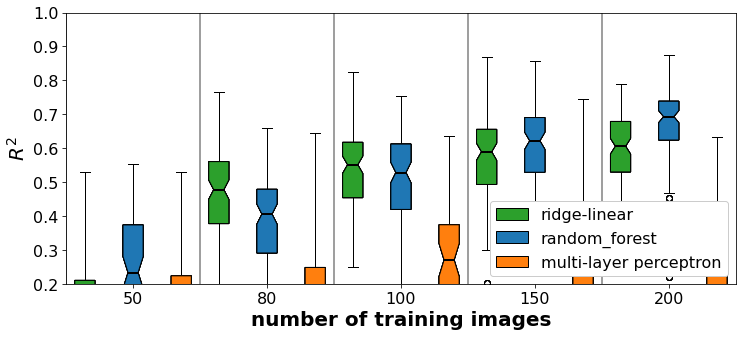

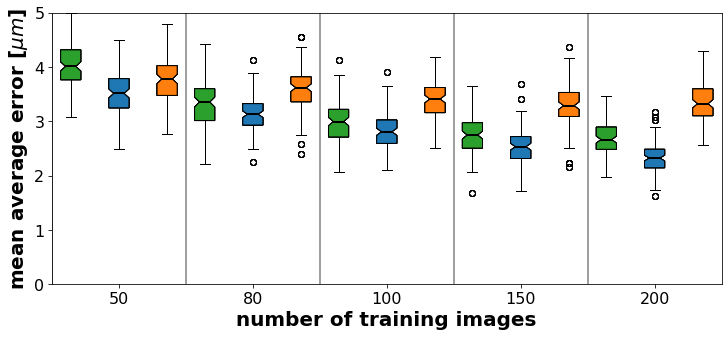

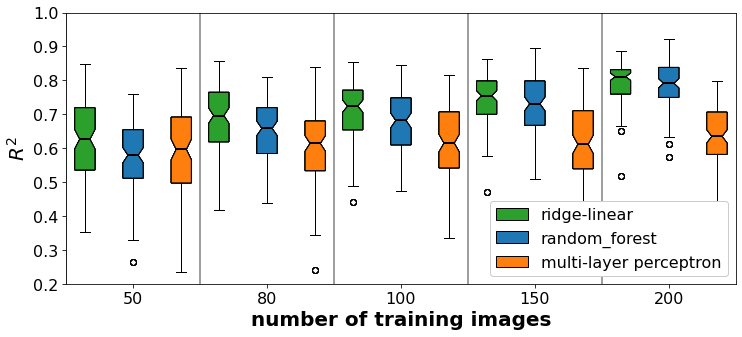

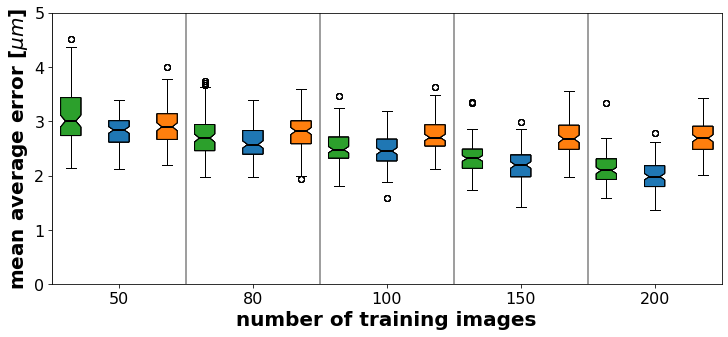

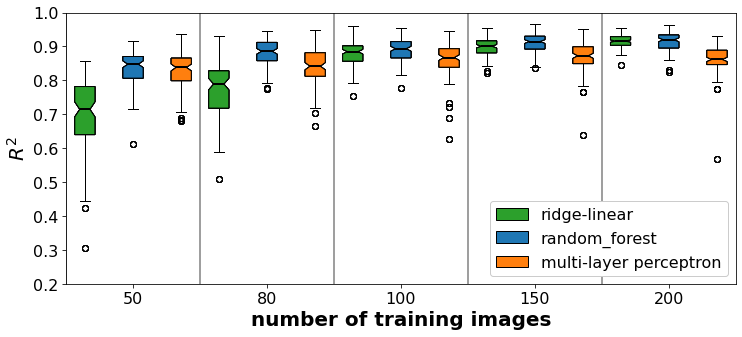

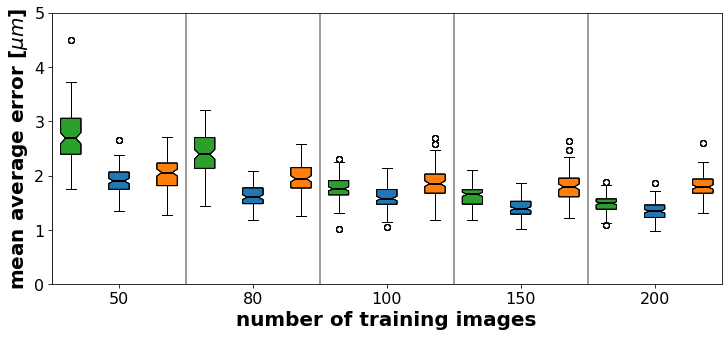

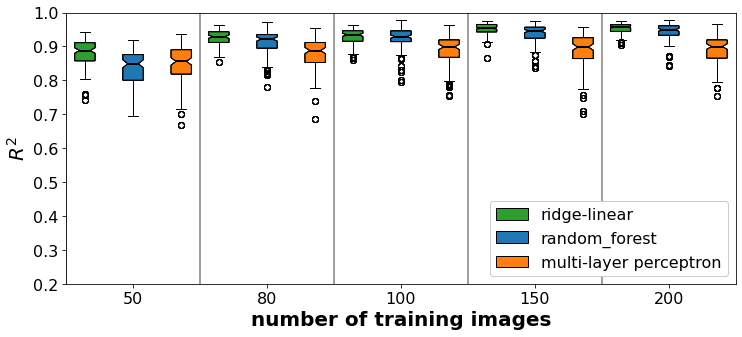

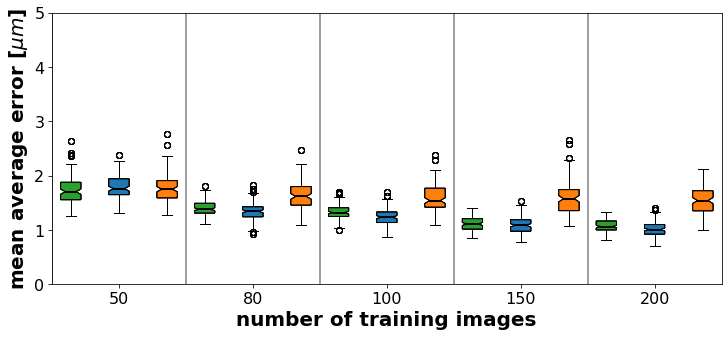

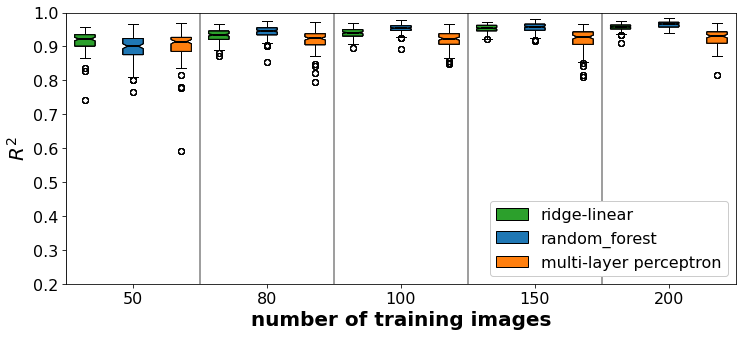

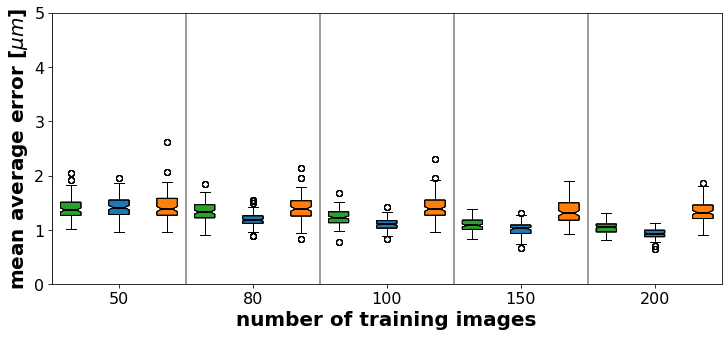

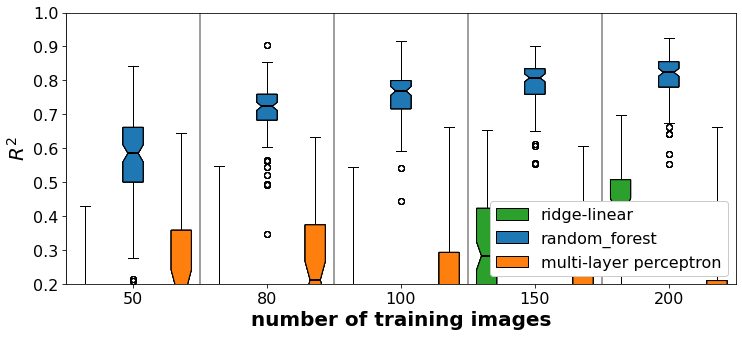

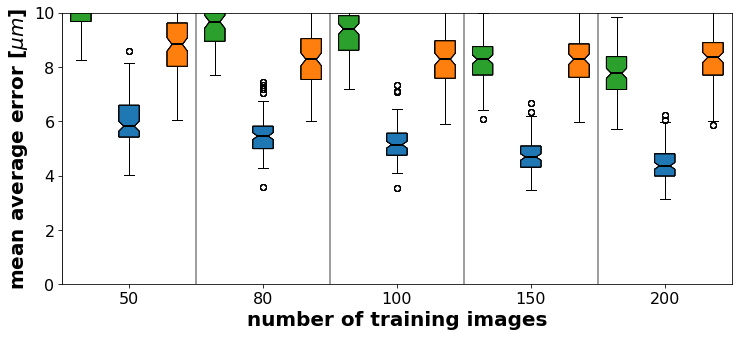

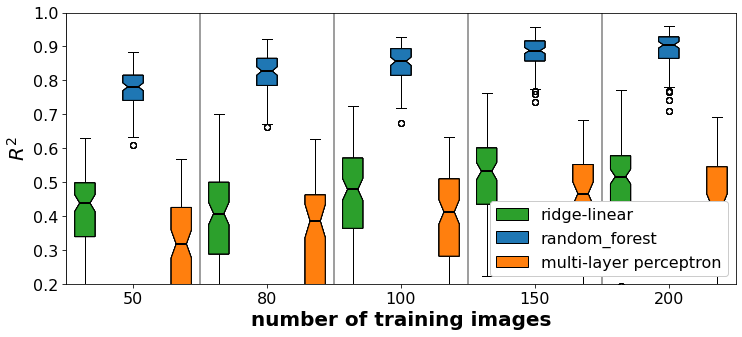

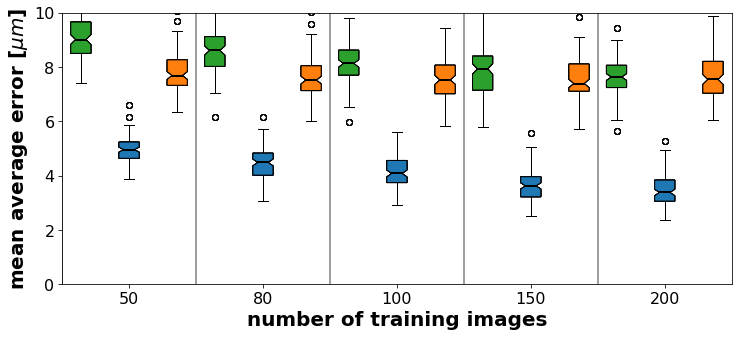

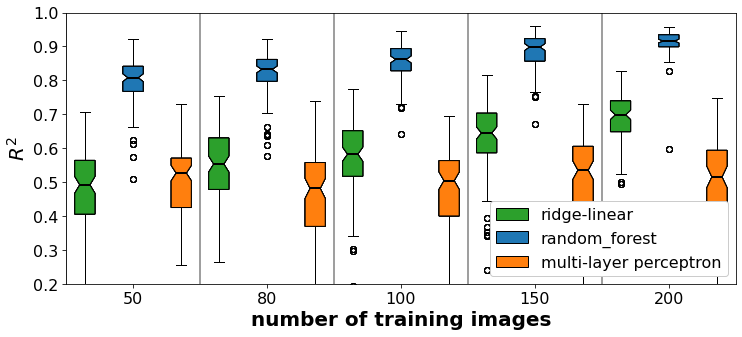

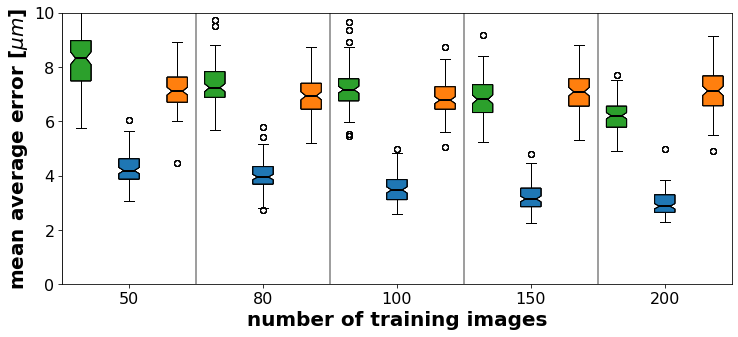

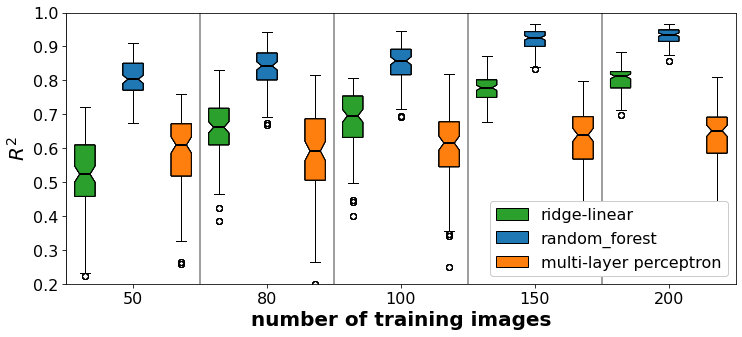

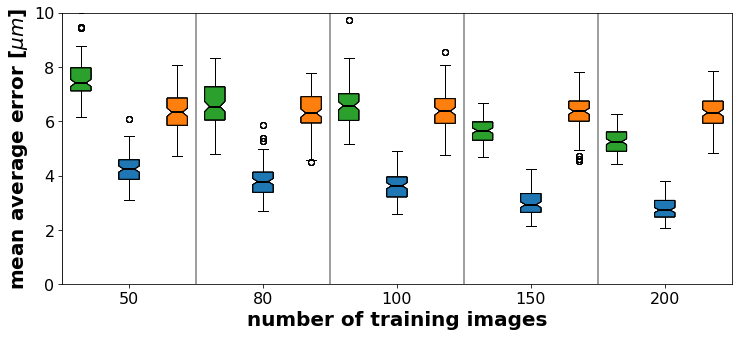

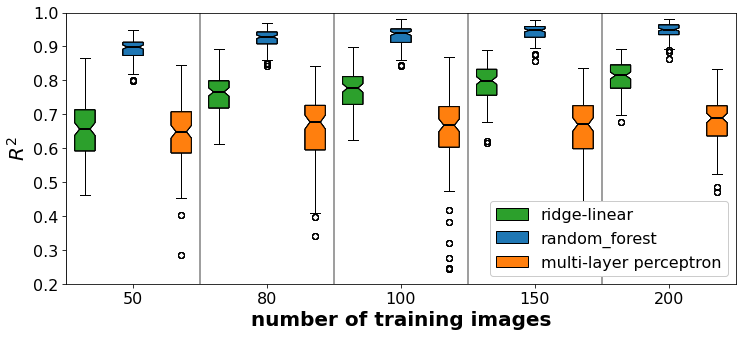

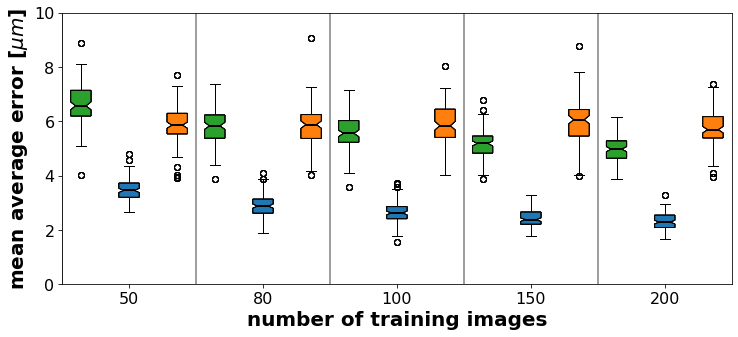

In [ ]:
edge_percentage_threshold = np.array([0.00, 0.01, 0.02, 0.05, 0.10])
cap = np.array([20, 50])
valid_images_size = np.array([[2653, 2231, 1811, 1013, 510], [5878, 4943, 3995, 2235, 1186]])
training_data_size = np.array([10, 20, 50, 80, 100, 150, 200])
data_percentage_legend = np.arange(len(training_data_size))

color_method = ['C3', 'C1', 'C2', 'C3', 'C4']
# boxplot and violin plot parameters for better aesthetics
box_width = 0.15
shift = 0.3
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format

holder = {}
for i in range(len(cap)):
  for j in range(len(edge_percentage_threshold)):
    tempo = np.load('performance_log/level1/cap%i_cutoff%1.2f_valid%i.npz' %(cap[i], edge_percentage_threshold[j], valid_images_size[i, j]), allow_pickle=True)
    holder.update({i * 10 + j: tempo})


for i in range(len(cap)):
  for j in range(len(edge_percentage_threshold)):
# plot R_squared.
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    ax.set_ylim(0.2, 1.0)

    for k in range(2, len(training_data_size)):
      box0 = plt.boxplot([np.reshape(holder[i * 10 + j]['ridge'][k, :, 0], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) - shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))
      box1 = plt.boxplot([np.reshape(holder[i * 10 + j]['rf'][k, :, 0], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) , notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))
      box2 = plt.boxplot([np.reshape(holder[i * 10 + j]['mlp'][k, :, 0], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) + shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

    for p in range(6):
      ax.vlines(1.5 + p, 0.2, 1.0, colors='grey')
    ax.set_xticks((data_percentage_legend + 1))
    ax.set_xticklabels((training_data_size).astype(str))
    ax.set_xlim(2.5, 7.5)
    ax.tick_params(labelsize=16, length=4)
    ax.set_xlabel(r'number of training images', fontsize=20, fontweight='bold')
    ax.set_ylabel(r'$R^{2}$', fontsize=20, fontweight='bold')
    ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0]], ['ridge-linear', 'random_forest', 'multi-layer perceptron'], fontsize=16, loc='lower right', framealpha=1)

# plot mean average error
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    if i == 0:
      ax.set_ylim(0, 5)
    else:
      ax.set_ylim(0, 10)

    for k in range(2, len(training_data_size)):
      box0 = plt.boxplot([np.reshape(holder[i * 10 + j]['ridge'][k, :, 1], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) - shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))
      box1 = plt.boxplot([np.reshape(holder[i * 10 + j]['rf'][k, :, 1], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) , notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))
      box2 = plt.boxplot([np.reshape(holder[i * 10 + j]['mlp'][k, :, 1], -1) for k in range(2, len(training_data_size))], widths=box_width, positions=np.arange(3, 8) + shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

    for p in range(6):
      if i == 0:
        ax.vlines(1.5 + p, 0, 5.0, colors='grey')
      if i == 1:
        ax.vlines(1.5 + p, 0, 10.0, colors='grey')
    ax.set_xticks((data_percentage_legend + 1))
    ax.set_xticklabels((training_data_size).astype(str))
    ax.set_xlim(2.5, 7.5)
    ax.tick_params(labelsize=16, length=4)
    ax.set_xlabel(r'number of training images', fontsize=20, fontweight='bold')
    ax.set_ylabel(r'mean average error [$\mu m$]', fontsize=20, fontweight='bold')
    # ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0]], ['ridge-linear', 'random_forest', 'multi-layer perceptron'], fontsize=16, loc='lower right', framealpha=1)



In [ ]:
print(np.average(holder[i * 10 + j]['rf'], axis=1))
print(np.std(holder[i * 10 + j]['rf'], axis=1))

[[-0.21639083  7.47460511]
 [ 0.69821329  5.12855177]
 [ 0.89179968  3.47963082]
 [ 0.9233557   2.90292342]
 [ 0.93089882  2.66149753]
 [ 0.94185578  2.43684   ]
 [ 0.9463053   2.31654862]]
[[0.74898413 1.07219296]
 [0.12144482 0.70805477]
 [0.03172447 0.44216891]
 [0.0258458  0.40550791]
 [0.0282795  0.39263678]
 [0.02288682 0.32602473]
 [0.02268225 0.32143601]]
